### Image Processing 
### JPEG compression/decompression
Fisseha Ferede <br> 4/21/2022

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Quantization Matrix
Two different types of quantization matrices are used. Here the two standard quantization matrices, Q50 and Q90 are defined. We can clearly see that both of these matrices have smaller values in the top left corners and larger values in the bottom right corners. The main purpose of quantizing a given Discrete Cosine Transform (DCT) is to have more repeatitive values (0s in the bottom right corner) such that the total number of unique values is reduced while retaining the most important frequency, DC, value in the top left corner. 

In [3]:
#Quantization matrices 
Q50 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
     [12, 12, 14, 19, 26, 58, 60, 55],
     [14, 13, 16, 24, 40, 57, 69, 56],
     [14, 17, 22, 29, 51, 87, 80, 62],
     [18, 22, 37, 56, 68 ,109 ,103 ,77],
     [24, 35, 55, 64, 81 ,104 ,113 ,92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 103, 99]])

Q90 = np.array([[3, 2, 2, 3, 5, 8, 10, 12], 
                [2, 2, 3, 4, 5, 12, 12, 11], 
                [3, 3, 3, 5, 8, 11, 14, 11],
                [3, 3, 4, 6, 10, 17, 16, 12], 
                [4, 4, 7, 11, 14, 22, 21, 15],
                [5, 7, 11, 13, 16, 12, 23, 18],
                [10, 13, 16, 17, 21, 24, 24, 21],
                [14, 18, 19, 20, 22, 20, 20, 20]])

In [23]:
#read img in YCR space
def readImgAsYCR(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    return img
#read img in RGB space
def readImgAsRGB(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [5]:
Lenna = readImgAsYCR('Data/Assign1/Lenna.png')

In [6]:
def resultSubplot(imgs, nrows, ncols, label):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16), constrained_layout=True)
    
    for ax, img, lab in zip(axs.flatten(), imgs, label):
        ax.set_title("Subplot row %s \n" % 2, fontsize=16)
        ax.imshow(img)
        ax.set_title(lab, color ='black', fontsize=16)
        ax.axis('off')

In [7]:
images = [Lenna[:,:,0], Lenna[:,:,1], Lenna[:,:,2]]
label = ['Y', 'Cb', 'Cr']

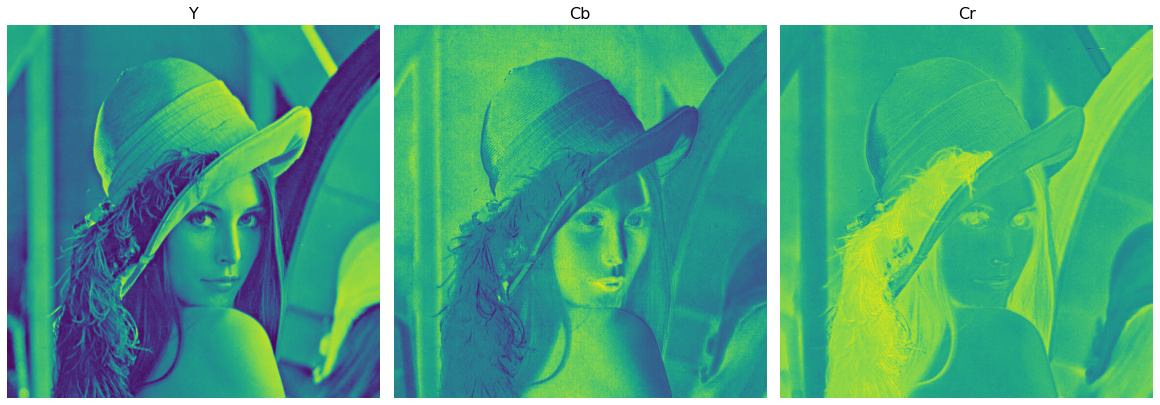

In [8]:
resultSubplot(images, 1, 3, label) 

In [9]:
#discrete cosine transform and inverse discrete cosine transform
from scipy.fftpack import dct, idct
def dct2(img):
    #discrete cosine transform
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

def idct2(img):
    #inverse discrete cosine transform
    return idct(idct(img.T, norm='ortho').T, norm='ortho')

#### ZigZag Encoding 
The _zigZagEncoding_ function encodes a given $2D$ array into a $1D$ array such that each elements are stored starting from top left corner to bottom right corner. This is important to encode the $DC$ values of $DCT$ transformed frequency values in such a way that the non zero values are on the left side of the array and the zeros are on the right. This way our $RLE encoding$ will be effective as we enounter so many consectuive zeros with this pattern.

In [10]:
def zigZagEncoding(M):
    r, c = M.shape
    zigZag = [[] for i in range(r+c-1)]
    for i in range(r): 
        for j in range(c):
            Sum = i+j  #over a given diagonal the sum of the i'th and j'th indices is const
            if (Sum %2 == 0): #if sum is divisible by 2, its the begining of the trace in zigzag path
                zigZag[Sum].insert(0, M[i,j])
            else:
                zigZag[Sum].append(M[i,j])
    
    arranged = []
    for i in zigZag:
        for j in i:
            arranged.append(j)
    return arranged

#### ZigZag Decoding
The _zigZagDecoding_ function decodes a zigzagEncoded array into a $2D$ array. This function is used in the reconstruction/decompression process to reconstruct the $1 \times 64$ Zigzag encoded array back to $8 \times 8$ block $DCT$.

In [11]:
def flipArray(M):
    T = []
    for i in range(len(M)):
        T.append(M[-(1+i)])
    return T

def zigZagDecoding(arranged, m):
    
    zigZag = [[] for i in range(2*m-1)]
    flipArranged =  flipArray(arranged)
    s0=0
    s1=1
    #generate the diagonals of the 8x8 matrix by tracing back in an inverse zigzag pattern
    for i in range(m):
        if i < m-1:
            zigZag[i] = arranged[s0:s1]
            zigZag[-(1+i)] =  flipArray(flipArranged[s0:s1])
            s0 = s1
            s1 = s1+i+2
        else:
            zigZag[i] = arranged[s0:s1]
                       
    Y = np.zeros((m,m)) 
    A = np.zeros(2*m-1)
    #arrange the diagonals in such a way that the 8x8 matrix is reconstructed
    for i in range(m):
        for j in range(m):
            S = i+j
            if S%2==0:
                Y[i,j] = flipArray(zigZag[S])[int(A[S])]
                A[S]+=1
            else:
                Y[i,j]=zigZag[S][int(A[S])]
                A[S]+=1
    return Y

#### Run Length Encoding/Decoding ####

The functions ***RLE_encoding*** and ***RLE_decoding*** are used to encode a give and decode a give array using Run length encoding. Such that neighbouring repeating values are encoded by two values, the first one representing the frequency of occurance of a give value, and the second one representing the value repeating itself. <br>
$E.g.$ $[1,2,2,2,4,4,4,6,6]$
<br>
is encodes as: <br>
$[1,1,3,2,3,4,2,6]$

To mean that 1 1s, 3 2s, 2 4s and 2 6s. This helps to encode the repeating zeros in just fewer bits.
In reconstruction phase, this RLE encoded array is decoded to original form.

In [12]:
def RLE_encoding(M):
    A = []
    i = 0
    while i < len(M):
        count = 1
        while(i+count<len(M)):
            if(M[i+count-1] == M[i+count]): #count the freq of repeating neighbouring values
                count+=1
            else:
                break
        A.append(count)
        A.append(M[i])
        i += count
    return A

def RLE_decoding(M):
    A = []
    for i in range(0, len(M), 2):
        for j in range(int(M[i])):
            A.append(M[i+1])
    return A

### Huffman Encoding/Decoding

The _huffmanEncoderDecoder_ function encodes a given array using variable lenth binary-code based on _HUFFMAN_ coding algorithm such that the most frequent values are encoded with fewer bits compared to least frequent values. The goal is to minimize the total number of bits used to encode the array in binary form. We can either _RLE_ or _Huffman encoding_ to reduce the size of the compressed image.

In [24]:
from heapq import heappush, heappop, heapify
from collections import defaultdict
from bitarray import bitarray
#generate the freq of occurances each values in a give 1D array
def freqGenerator(M):
    freq_lib = defaultdict(int)

    for ch in M: 
        freq_lib[ch]+=1
    return freq_lib
    
def huffmanEncoderDecoder(M):
    #encoding
    freq_lib = freqGenerator(M)
    
    heap =[[count, [sym, ""]] for sym, count in freq_lib.items()]
    heapify(heap) #creat a heap data structure from a binary tree
    
    while len(heap) > 1:
        right = heappop(heap)

        left = heappop(heap)

        for pair in right[1:]:
            pair[1] = '0' + pair[1] #add zero to right node

        for pair in left[1:]:
            pair[1] = '1' + pair[1] #add one to left nodes

        heappush(heap, [right[0] + left[0]] + right[1:] + left[1:])
        
    huffman_list = right[1:] + left[1:]
    huffman_dict = {a[0]:bitarray(str(a[1])) for a in huffman_list}

    encoded_text = bitarray()
    encoded_text.encode(huffman_dict, M)

    padding = 8 -(len(encoded_text)%8) #encoding in bytes (padding to ensure bits are multiples of 8)
    
    #save the encoded text
    with open('compressed_image_file.bin', 'wb') as w:
        encoded_text.tofile(w)
        
    decoded_text = bitarray()
    
    '''Decoding'''
    with open('compressed_image_file.bin', 'rb') as r:
        decoded_text.fromfile(r)
   
    AsList = list(freq_lib.items())
    L = len(AsList)
    s = 0
    for i in range(L):
        s+=list(freq_lib.items())[i][1]

    
    decoded_text = decoded_text[:-padding]
     
    if ( (len(decoded_text)==0) or (s==L)):
        decoded_text = M
        return decoded_text, encoded_text

    decoded_text = decoded_text.decode(huffman_dict)
    
    return decoded_text, encoded_text

The JPEG compression decompression function is built using the predefined function, each of them having a specific step to do.

_Compression_

1.  Downsample the chroma blue and red components of the img in YCbCr format. We do this because the Illuminance has more importance in human visual and downsampling these two components helps to create more similar values without affecting the result much.
2. Create an $8 \times 8$ blocks from. 
3. Apply Discrete Cosine Transform on each 8x8 block.
4. Quantization using the standard $8 \times 8$ quantization matrix. Quantization is done by dividing each components of the $8 \times 8$ block by different values such that frequency values in the top left corner are retained and the values at the bottom right corner are approximated to zero.
5. Apply _ZigZag_ encoding such that the $8 \times 8$ block is converted to $1 \times 64$ array containing DC values on the left side, and AC values (mostly zeros) on the right bottom corner.
6. Apply _RLE encoding_ on the zigZag encoded array such that repeting neighbouring points are stored with their value and its number of occurances. $E.g. [2,2,2,2,2]$ is stored as $[5,2]$ implying that there are $5 2s$. 
7. Apply _Huffman coding_ on the RLE encoded array. Using variable encoding length such that the most frequently occuring values are encoded with fewer bits, and instead of using fixed length encoding.

_Decompression_

1. Decode the huffman coded array (in bytes) to reconstruct it to RLE encoded form.
2. Apply RLE decoding on the decoded huffman values to reconstruct to ZigZag array
3. Apply zigZag decoding to reconstruct reconstructed DCT frquency values.
4. Apply inverse DCT on each 8x8 block to reconstruct each 8x8 image blocks.
5. Merge each reconstructed 8x8 blocks such that the reconstructed image is former.

In [14]:
#JPEG compression/decompression
#arguments: img - in YCRCB format,  f - downsampling factor for Cr and Cb, Q, quantizan, 
#Huffman has boolean val(to apply entropy encoding or not instead of RLE encoding)
def JPEGcompressionDecompression(img, f, Q, Huffman):
    h,w,c = img.shape
    
    #window size
    s = 8 
    
    img = np.asarray(img)
    img[:,:,1] = f*np.around(img[:,:,1]/f) #downsample the Chroma Blue component
    img[:,:,2] = f*np.around(img[:,:,2]/f) #downsample the Chroma Red component
      
    A = np.zeros_like(img)
    D = []
    for i in range(c):
        for j in range(0,w,s):
            for k in range(0,h,s):
                I = img[k:k+s, j:j+s, i] #create an 8x8 block

                I_dct = dct2(I) #apply DCT

                I_quant =  (Q*np.around(I_dct/Q)) #Apply Quantization
            
                I_zigEnc = zigZagEncoding(I_quant) #zigzag Encoding

                #hufDec is the recostructed version, hufEnc is the compressed version in bytes
                if(Huffman): #apply huffman entropy encoding
                    hufDec, hufEnc = huffmanEncoderDecoder(I_zigEnc) #huffman encoding decoding
                    D.append(hufEnc)
                    I_zigDec = zigZagDecoding(hufDec, s) #Zigzag decoding, here we reconstructed the 8x8 blocks
                    
                else:
                    I_RLE_Enc = RLE_encoding(I_zigEnc) #Rle Encoding
                    D.append(I_RLE_Enc)
                    I_RLE_Dec = RLE_decoding(I_RLE_Enc)
                    I_zigDec = zigZagDecoding(I_RLE_Dec, s) #Zigzag decoding, here we reconstructed the 8x8 blocks
                
                I_invDct = np.asarray(idct2(I_zigDec)).astype('uint8') #inverse DCT

                A[k:k+s, j:j+s, i]= I_invDct #reconstructed 8x8 image
            
    Reconstructed, compressed = A,D
    return Reconstructed, compressed

In [16]:
Lenna = readImgAsYCR('Data/Assign1/Lenna.png')
Reconstructed1, compressed1 = JPEGcompressionDecompression(Lenna, 2, Q50, True)
Reconstructed2, compressed2 = JPEGcompressionDecompression(Lenna, 12, Q90, False)
Reconstructed3, compressed3 = JPEGcompressionDecompression(Lenna, 40, Q50, False)

In [17]:
Reconstructed_rgb1 = cv2.cvtColor(Reconstructed1, cv2.COLOR_YCR_CB2RGB)
Reconstructed_rgb2 = cv2.cvtColor(Reconstructed2, cv2.COLOR_YCR_CB2RGB)
Reconstructed_rgb3 = cv2.cvtColor(Reconstructed3, cv2.COLOR_YCR_CB2RGB)
original_Img = readImgAsRGB('Data/Assign1/Lenna.png')

Results are plotted in RGB space. Each of the three decompressed images have different combinations of downsampling factor, Q matrix. As we can see even by decompressinge the Chroma red and chroma blue components of the YCR space by 1/40, we can still get a good quality image.

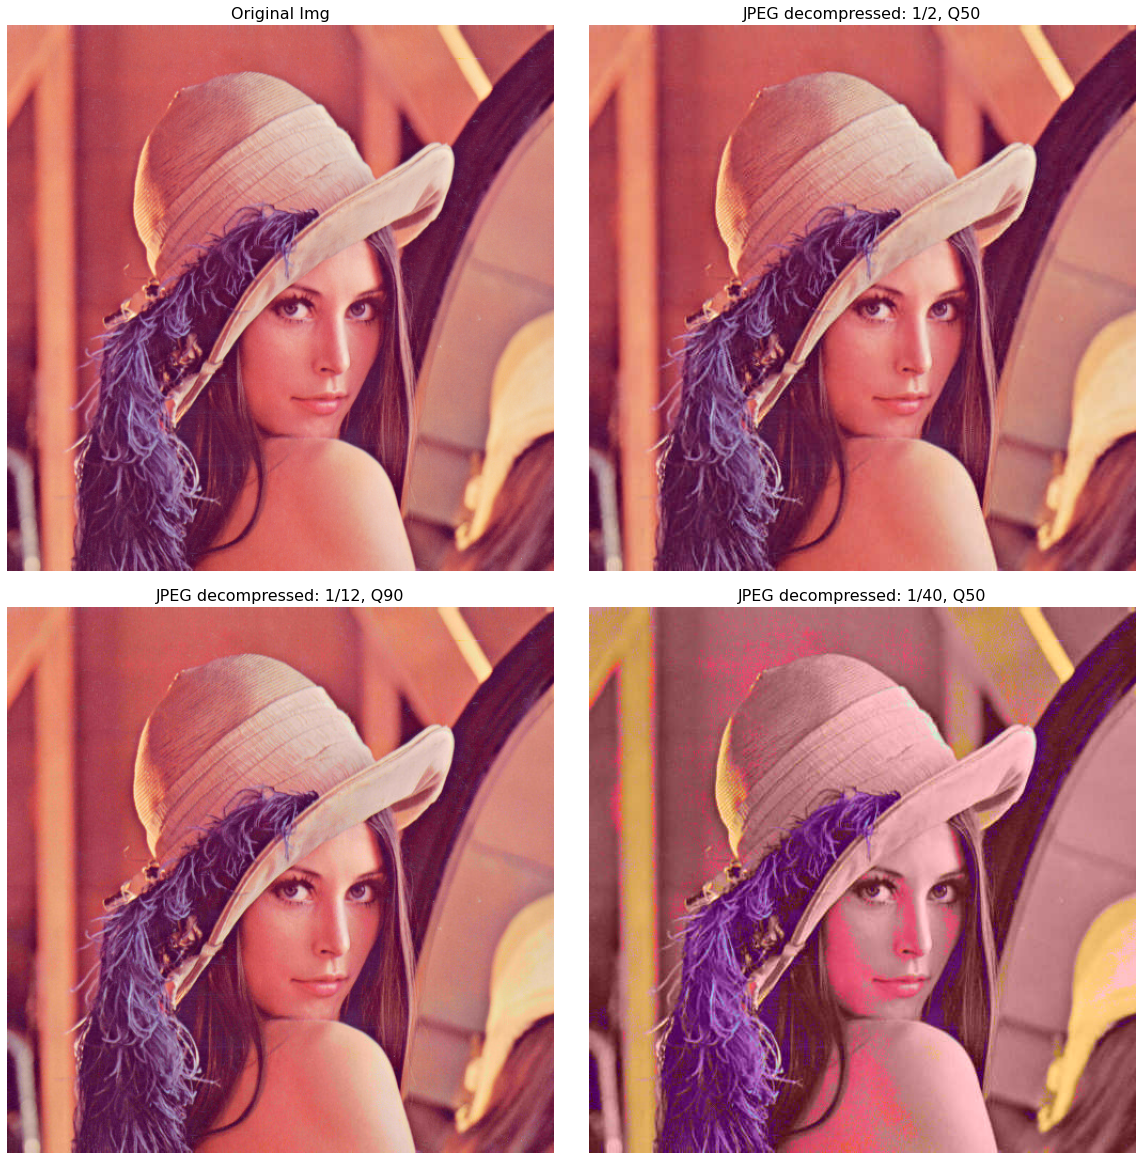

In [22]:
Imgs = [original_Img, Reconstructed_rgb1, Reconstructed_rgb2, Reconstructed_rgb3]
label = ['Original Img', 'JPEG decompressed: 1/2, Q50', 'JPEG decompressed: 1/12, Q90', 'JPEG decompressed: 1/40, Q50']
resultSubplot(Imgs, 2, 2, label)

In [19]:
compressed1[1:20] #hufman encoded JPEG compressed image in bytes

[bitarray('011111001111111111111111111111111111111111111111111111111111111111'),
 bitarray('0111111111111111111111111111111111111111111111111111111111111111'),
 bitarray('011001111111111111111111111111111111111111111111111111111111111111'),
 bitarray('011001111111111111111111111111111111111111111111111111111111111111'),
 bitarray('0111111111111111111111111111111111111111111111111111111111111111'),
 bitarray('011110011111111111111111111111111111111111111111111111111111111111'),
 bitarray('011001000101011111111111111111111111111111111111111111111111111111111111'),
 bitarray('001110100111111111111111111111111111111111111111111111111111111111111'),
 bitarray('011010001110001111111111111111111111111111111111111111111111111111111111'),
 bitarray('00100001110110010001011111111111111111111111111111111111111111111111111111111111'),
 bitarray('0111011001011001011000000010011110100111111111111111111111111111111111111111111111111111'),
 bitarray('000001010100111011010100011111111111111111111111111

In [26]:
import sys
sys.getsizeof(compressed1)

98624

In [27]:
sys.getsizeof(original_Img)

786560

In [29]:
LosslessCompressionRatio = sys.getsizeof(original_Img) / sys.getsizeof(compressed1)

In [30]:
LosslessCompressionRatio

7.975340687865023

We can see that the image is compressed 8 times using loosless JPEG compression